In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(1, 'src/')
from src import utilities
import config
import csv

from fastai import *
from fastai.text import *

In [4]:
# import data
SARC_DATA = config.SARC_DATA
SARC_MAIN = config.SARC_MAIN
SARC_POL = config.SARC_POL

train_path = SARC_MAIN + 'train-balanced.csv'
test_path = SARC_MAIN + 'test-balanced.csv'
comment_path = SARC_MAIN + 'comments.json'

train_docs, test_docs, train_labels, test_labels = \
    utilities.load_sarc_responses(train_path, test_path, comment_path)

In [5]:
print(train_docs.keys())

dict_keys(['ancestors', 'responses'])


In [6]:
len(train_docs['ancestors']), len(train_docs['responses'])

(128541, 128541)

In [7]:
# Create csv data file in format for training
learn_data = []

for index, label in enumerate(train_labels):
    ancestor = train_docs['ancestors'][index][0]
    response1 = train_docs['responses'][index][0]
    response2 = train_docs['responses'][index][1]
    label1 = label[0]
    label2 = label[1]
    learn_data.append([label1, ancestor + ' - ' + response1])
    learn_data.append([label2, ancestor + ' - ' + response2])

with open('bunch_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(learn_data)

In [8]:
bs=48

In [9]:
torch.cuda.set_device(0)

In [10]:
# Load databunch for lm training
ml_bunch = TextLMDataBunch.from_csv(path='.', csv_name='bunch_data.csv')

In [11]:
len(ml_bunch.vocab.itos),len(ml_bunch.train_ds)


(60000, 205664)

In [12]:
ml_bunch.show_batch()

idx,text
0,"89 % ban rate in platinum+ so the juggernauts ( skarner morde garen and darius ) have all a ban rate from 65 % -90 % - xxmaj riot 's xxup tsm favoritism is shining xxbos xxmaj five xxmaj games xxmaj that xxmaj should be on or xxmaj localized for the xxup ps xxmaj vita - persona 5 . sad that its going to be ps4 only . xxbos """
1,"xxmaj african xxmaj food xxmaj for xxmaj the xxmaj first xxmaj time - i am triggered by all this racism guys ! xxbos xxmaj canadian xxmaj newspaper takes down article about refugee children choking other kids with a chain shouting "" xxmaj muslims will rule the world "" because cucks complained - xxup religion xxup of xxup peace e l i g i o n o f p e a"
2,"with your sister really well xxbos xxmaj bears xxup hc xxmaj john xxmaj fox on rookie xxup rb xxmaj jordan xxmaj howard : "" xxmaj he 's outstanding , and we 'll ride him pretty good moving forward . "" - xxmaj at least until 4th and 1 , then it 's xxmaj bell cow baby ! xxbos xxmaj brewery apologizes after "" xxmaj date xxmaj grape "" submission on"
3,"its pit bull ban - xxmaj wonder how long before someone xxunk posts a photo of the breed with a toddler saying "" xxup see "" . xxbos xxmaj man holds gamestop clerk at gunpoint , steals playstation xxmaj vita , xxmaj orlando cops say | xxmaj news - xxmaj gamestop - xxmaj power to the xxmaj players xxbos xxmaj for those pesky gamer viruses - xxmaj got ta protect"
4,"uw - xxmaj madison xxmaj student xxmaj creates xxmaj sweatshirt xxmaj that xxmaj says "" xxmaj all white xxmaj people xxmaj are xxmaj racist "" - xxmaj definition of irony xxbos i think you 'll enjoy my reppin it at my graduation xxup :p - pretty nice , only wondering what is it made of ? xxbos xxmaj neverwet on xxmaj skin , this stuff is xxmaj awesome - how"


In [13]:
# Save databunch
ml_bunch.save('lm_databunch')


In [14]:
# load databunch
data_lm = load_data('.', 'lm_databunch', bs=bs)


In [15]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [18]:
wiki103 = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))


In [19]:
vocab = data_lm.vocab

In [21]:
vocab.stoi['stingray']

19214

In [22]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


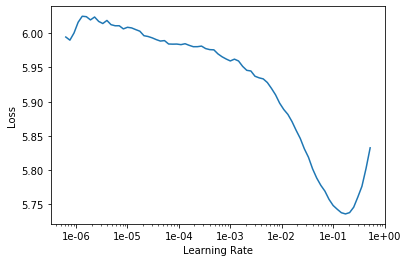

In [23]:
learn_lm.recorder.plot(skip_end=15)

In [24]:
lr = 2e-2
lr *= bs/48

In [25]:
learn_lm.to_fp16()


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (205664 items)
x: LMTextList
xxbos xxmaj only a very , very , very small preview . - xxwrep 5 skyactive xxmaj dynamic xxmaj fuels skyactive skyactive skyactive skyactive,xxbos xxup til that the xxmaj roman xxmaj emperor xxmaj nero bought a young boy , married him , castrated him and dressed him up as a girl at public events . - xxmaj what an artist died in him .,xxbos xxmaj darius has a 89 % ban rate in platinum+ so the juggernauts ( skarner morde garen and darius ) have all a ban rate from 65 % -90 % - xxmaj riot 's xxup tsm favoritism is shining,xxbos xxmaj five xxmaj games xxmaj that xxmaj should be on or xxmaj localized for the xxup ps xxmaj vita - persona 5 . sad that its going to be ps4 only .,xxbos " xxmaj diversity is good , but a lack of diversity is n't bad . " - xxmaj so smug .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (51417 items)
x: LMTextList
xxbos xxmaj how to win at xxunk : xxmaj hold " l " - xxmaj the year i

In [ ]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8, 0.7))

In [ ]:
learn_lm.unfreeze()

In [ ]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

In [ ]:
learn_lm.save('fine_tuned')
learn_lm.save_encoder('fine_tuned_enc')

In [ ]:
learn_lm.load('fine_tuned')
